### Imports, mount

In [2]:
# mounting notebook with my google drive environment 
from google.colab import drive
drive.mount('/content/drive')

# set working path to 'SEB_task_portfolio' directory
%cd '/content/drive/My Drive/SEB_task_portfolio/'
print('\nFiles:')
!dir

# importing our created functions for calculations
from function import *

# importing other libraries
import scipy.stats as stats

# interest rate
r = 0.2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SEB_task_portfolio

Files:
function.py  portfolio_analysis.ipynb  __pycache__  Test_candidates.xlsx


### Data

In [3]:
# Loading and display data
data, portfolio = load_data('Test_candidates.xlsx')

# display portffolio
portfolio

,Instrument,Company,Position,Strike,Tenor*
0,Shares,Google,300,NaN,NaN
1,Put,Google,300,700,1 month
2,Call,Google,-300,850,1 month
3,Call,Apple,200,390,1 month
4,Put,Apple,200,390,1 month
5,Call,Apple,-400,450,1 month
6,Shares,Amazon,-200,NaN,NaN
7,Call,Amazon,100,280,1 month
8,Call,Amazon,100,300,1 month


# Question 1: 

## What was the portfolio value on the 19th April 2013?

In [4]:
# setting a date
date='2013-04-17'

# calling a function which returns portfolio value at given day
portfolio_value_2013_04_19 = np.round(portfolio_value(date=date, stock_data=data, portfolio_data=portfolio, r=r), 2)

# printing portfolio value
print('Portfolio value on {} is {}'.format(date, portfolio_value_2013_04_19))

Portfolio value on 2013-04-17 is 202681.84


### Answer



*   Portfolio value on 2013-04-17 is 202681.84







## To which risk factors is the portfolio most sensitive?

### With Greeks

In [5]:
# creating Greek parameters list at given day for all assets in portfolio
greeks_list = portfolio_greeks(date=date, stock_data=data, portfolio_data=portfolio, r=r)

# creating Greek parameters dataframe
greeks_df = pd.DataFrame(greeks_list, columns=['Delta', 'Gamma', 'Theta', 'Vega', 'Rho'])

# concatinating portfolio dataframe with Greeks parameters dataframe for better visualization of data
portfolio_and_greeks = pd.concat((portfolio, greeks_df), axis=1, ignore_index=True)
portfolio_and_greeks.columns = ['Instrument', 'Company', 'Position', 'Strike', 'Tenor*', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
portfolio_and_greeks

,Instrument,Company,Position,Strike,Tenor*,Delta,Gamma,Theta,Vega,Rho
0,Shares,Google,300,NaN,NaN,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000e+00
1,Put,Google,300,700,1 month,-4.284008e-05,2.908898e-08,131.137822,4.023017e-02,-5.736635e+01
2,Call,Google,-300,850,1 month,9.999525e-01,3.205766e-08,-7.216413,4.433586e-02,3.084472e-03
3,Call,Apple,200,390,1 month,1.000000e+00,2.991372e-14,-0.000005,1.842688e-08,7.917979e-10
4,Put,Apple,200,390,1 month,-2.356323e-11,2.991372e-14,76.710768,1.842688e-08,-3.196282e+01
5,Call,Apple,-400,450,1 month,1.000000e+00,3.213189e-14,-0.000005,1.979327e-08,8.491643e-10
6,Shares,Amazon,-200,NaN,NaN,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000e+00
7,Call,Amazon,100,280,1 month,1.000000e+00,3.235082e-12,-0.000194,7.899485e-07,3.751914e-08
8,Call,Amazon,100,300,1 month,1.000000e+00,3.348522e-12,-0.000201,8.176486e-07,3.879846e-08


In [6]:
# printing mean values of each Greek parameters
print('Delta mean: {}'.format(portfolio_and_greeks['Delta'].mean()))
print('Gamma mean: {}'.format(portfolio_and_greeks['Gamma'].mean()))
print('Theta mean: {}'.format(portfolio_and_greeks['Theta'].mean()))
print('Vega mean: {}'.format(portfolio_and_greeks['Vega'].mean()))
print('Rho mean: {}'.format(portfolio_and_greeks['Rho'].mean()))

Delta mean: 0.7777677416087747
Gamma mean: 6.794812881542678e-09
Theta mean: 22.292419036401327
Vega mean: 0.009396410323286274
Rho mean: -9.702898997667418


#### Answer



*   As we see for Calls Delta is near 1 and for Puts - near to 0. It means that for Calls changing of underlying assets affects Call's values the same way (underlying assets raises for 1 leads to raise calls for 1 as well). For Puts, changes of underlying assets affects Puts values poorly (puts values remains more or less the same). Having mostly Calls, shares and only 2 Puts in whole portfolio, option behaves like the underlying security as shares does in terms of price changes. Overall - portfolio is sensitive for underlying asset price changes. Mean Delta value is 0.77 which tells that in average portfolio value changes in 0.77xchanges speed.
*  Also we can notice, Gamma values for whole portfolio subjects tend to be close to 0 what tells us that Delta doesn't tend to change when underlying security changes in price. Deltas tend to keep same values - big for Calls which leads for keeping portfolio sensitive for changes in underlying asset prices. Mean Gamma value is 0.00000000679 that is ~ 0.
*  Theta values, which represents how time affects option values, for Puts are big positive(but only two Puts in whole portfolio) and for Calls (majoroty of assets in whole portfolio) - small negative. In the other hand mean Theta value is 22.29 which is an indicator that even majority of assets are calls and shares, for puts time means a lot and overall portfolio is sensitive for time.
*  Vega tells how volatility of price gonna change or how option price changes while implied volatily changes as well. For all the options in portfolio Vega values are really small what means that changes in implied volatility impacts portfolio value in a really small step as well.They are all small positive values which tells that if implied volatility raises, portfolio value raise reallly small as well and vice versa. So implied volatility isn't a factor to which portfolio is really sensitive. Mean Vega value is 0.009.
*  Rho measures the sensitivity of an option to a change in interest rate. As we see from Rho values that only Puts has big absolute Rho values (big negatives) which says that changes in interest rates affects Puts values in the oposite direction (if interest rates decreases then Put values increases and vice versa). For Calls Rho values are really small positives, nearly close to 0 which means that changes in interest rates really poorely affects Call option values. Even majority of options are calls, mean Rho value is -9.70 which says that when interest rate increases portfolio value decreases by 9.7 points.

*  **Resume**:
Overall it seems that underlying asset price (stock price) plays biggest role for portfolio changes (Delta). Secondary comes time or Theta, and thirdy - interest rate or Rho. Portfolio is most sensitive for these parameters by the same order.

### With ML

In [7]:
# creating new dataframe with existing data of stock prices 
# and portfolio data for machine learning algorithm
ml_data = data.copy()
ml_data['Position 1'] = 300
ml_data['Strike 1'] = 700
ml_data['Position 2'] = -300
ml_data['Strike 2'] = 850
ml_data['Position 3'] = 200
ml_data['Strike 3'] = 390
ml_data['Position 4'] = 200
ml_data['Strike 4'] = 390
ml_data['Position 5'] = -400
ml_data['Strike 5'] = 450
ml_data['Position 6'] = 100
ml_data['Strike 6'] = 280
ml_data['Position 7'] = 100
ml_data['Strike 7'] = 300
ml_data['Interest rate'] = 0.2
ml_data['Time'] = 1/12

# dataframe of portfolio values over time
portfolio_over_time = portfolio_values_over_time(stock_data=data, portfolio_data=portfolio)

# display dataframe for machine learning algorithm and portfolio values over time dataframe
display(ml_data.head(3))
display(portfolio_over_time.head(3))

,IMPL VOL Apple,Price Apple,IMPL VOL Amazon,Price Amazon,IMPL VOL Google,Price Google,Position 1,Strike 1,Position 2,Strike 2,Position 3,Strike 3,Position 4,Strike 4,Position 5,Strike 5,Position 6,Strike 6,Position 7,Strike 7,Interest rate,Time
Date,,,,,,,,,,,,,,,,,,,,,,
2010-06-01,44.97,257.04,51.18,123.24,41.00,482.37,300,700,-300,850,200,390,200,390,-400,450,100,280,100,300,0.2,0.083333
2010-06-02,43.26,260.11,46.68,126.31,38.11,493.37,300,700,-300,850,200,390,200,390,-400,450,100,280,100,300,0.2,0.083333
2010-06-03,40.29,259.29,45.58,128.76,35.79,505.60,300,700,-300,850,200,390,200,390,-400,450,100,280,100,300,0.2,0.083333


,Value
2010-06-01,231831.778759
2010-06-02,231217.779373
2010-06-03,231381.783040


In [0]:
# X_train - training features
X_train = ml_data.values

# Y_train - training targets
Y_train = portfolio_over_time.values

In [9]:
# creating Linear Regression model with Sklearn
model = LinearRegression()

# training model with given training features and targets
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# extracting trained model coeficients for each feature we fed
coeficients = np.abs(np.around(model.coef_, 3))
coeficients

array([[4.35000e-01, 1.99995e+02, 1.19400e+00, 2.15000e-01, 3.29000e+00,
        7.90000e-02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [11]:
# volatility feature coeficient
volatility_coef = np.round((coeficients[0][0] + coeficients[0][2] +  coeficients[0][4])/3, 3)

# stock price feature coeficient
price_coef = np.round((coeficients[0][1] + coeficients[0][3] +  coeficients[0][5])/3, 3)

# print coeficients mean values
print('Volatility coef: {}'.format(volatility_coef))
print('Price coef: {}'.format(price_coef))

Volatility coef: 1.64
Price coef: 66.763


#### Answer

Based Linear Regression model coeficients, biggest impact has Stock prices if we assumes only options and exclude Shares.  
Biggest absolute values of coeficients are for price features. Because model does not see changes in other features (rate, time on other) then it has no power to include them into fit process. Thats why it uses only two features from all of them to predict portfolio value and that's why only two coeficients we've got. From them in average bigger value has price's coef.

# Question 2:  

## At which date would the portfolio suffer the largest loss?

In [12]:
# first 5 portfolio values over time
portfolio_over_time.head()

,Value
2010-06-01,231831.778759
2010-06-02,231217.779373
2010-06-03,231381.783040
2010-06-04,232791.778967
2010-06-07,233781.778742


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


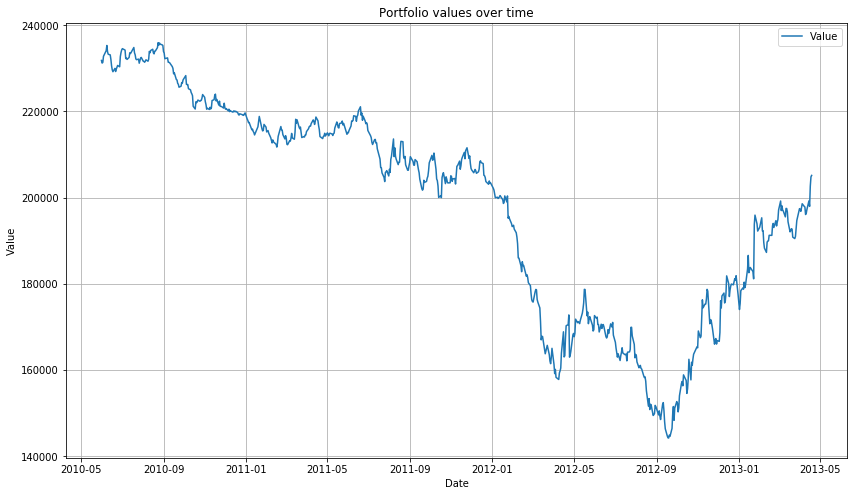

In [13]:
# plotting portfolio values over time
plt.figure(figsize=(14,8))
sns.lineplot(data=portfolio_over_time)
plt.title('Portfolio values over time')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [0]:
# min value of portfolio over time
min_value = portfolio_over_time.min().values[0]

# date when portfolio value was lowest
min_value_date = portfolio_over_time.loc[portfolio_over_time['Value'] == min_value].index[0]

In [15]:
# print result
print('Date when portfolio value was lowest is: {}'.format(min_value_date))

Date when portfolio value was lowest is: 2012-09-19 00:00:00


### Answer

Date when portfolio value was lowest (biggest loss) is: 2012-09-19


## How much did the risk factor move on that date?

 **Here I will calculate how much risk factors changed from the day before min porfolio value date till that day**

In [16]:
# portfilio value day before minimum portfolio value day
portfolio_value_min1 = portfolio_value(date='2012-09-18', stock_data=data, portfolio_data=portfolio, r=r)
# Greek parameter list of the day before minimum portfolio value day
greeks_list1 = portfolio_greeks(date='2012-09-18', stock_data=data, portfolio_data=portfolio, r=r)

# portfilio value on the day when portfolio value was minimum
portfolio_value_min2 = portfolio_value(date=min_value_date, stock_data=data, portfolio_data=portfolio, r=r)
# Greek parameter list on the day when portfolio value was minimum
greeks_list2 = portfolio_greeks(date=min_value_date, stock_data=data, portfolio_data=portfolio, r=r)

# printing results
print('Portfolio value on {} is {}'.format('2012-09-18 00:00:00', portfolio_value_min1))
print('Portfolio value on {} is {}'.format(min_value_date, portfolio_value_min2))

Portfolio value on 2012-09-18 00:00:00 is 144306.9362656965
Portfolio value on 2012-09-19 00:00:00 is 144269.39062939578


In [0]:
# Greek factors the day before minimum portfolio value dataframe
greeks_df1 = pd.DataFrame(greeks_list1, columns=['Delta', 'Gamma', 'Theta', 'Vega', 'Rho'])

# Greek factors on the day when porfolio value was minimum
greeks_df2 = pd.DataFrame(greeks_list2, columns=['Delta', 'Gamma', 'Theta', 'Vega', 'Rho'])

In [0]:
# Deltas mean values on both days
Delta1 = greeks_df1['Delta'].mean()
Delta2 = greeks_df2['Delta'].mean()

# Gammas mean values on both days
Gamma1 = greeks_df1['Gamma'].mean()
Gamma2 = greeks_df2['Gamma'].mean()

# Thetas mean values on both days
Theta1 = greeks_df1['Theta'].mean()
Theta2 = greeks_df2['Theta'].mean()

# Vegas mean values on both days
Vega1 = greeks_df1['Vega'].mean()
Vega2 = greeks_df2['Vega'].mean()

# Rhoes mean values on both days
Rho1 = greeks_df1['Rho'].mean()
Rho2 = greeks_df2['Rho'].mean()

In [19]:
# building both days Greek parameters mean values comparison dictionary
comparison_dict = {'Delta': [Delta1, Delta2], 'Gamma': [Gamma1, Gamma2], 'Theta': [Theta1, Theta2], 'Vega': [Vega1, Vega2], 'Rho': [Rho1, Rho2]}

# building both days Greek parameters mean values comparison dataframe
comparison_df = pd.DataFrame.from_dict(comparison_dict, orient='index', columns=['2012-09-18','2012-09-19'])

# display Greek parameters mean values in both days
display(comparison_df)

# display stock prices and volatilities day before minimum portfolio value day
display(display(get_row('2012-09-18', df=data)))
# display stock prices and volatilities when portfolio value was minimum
display(display(get_row(min_value_date, df=data)))

,2012-09-18,2012-09-19
Delta,7.777491e-01,7.777369e-01
Gamma,2.767338e-08,3.938902e-08
Theta,2.039853e+01,1.918546e+01
Vega,2.146332e-02,2.995216e-02
Rho,-9.702007e+00,-9.701332e+00


,IMPL VOL Apple,Price Apple,IMPL VOL Amazon,Price Amazon,IMPL VOL Google,Price Google
Date,,,,,,
2012-09-18,26.01,694.67,28.56,258.75,29.33,718.28


None

,IMPL VOL Apple,Price Apple,IMPL VOL Amazon,Price Amazon,IMPL VOL Google,Price Google
Date,,,,,,
2012-09-19,25.29,694.86,28.01,261.68,29.58,727.5


None

In [20]:
# changes of Greek parameters from day before minimum portfolio value day to that day
display(comparison_df['2012-09-18']-comparison_df['2012-09-19'])

Delta    1.226139e-05
Gamma   -1.171564e-08
Theta    1.213072e+00
Vega    -8.488840e-03
Rho     -6.748304e-04
dtype: float64

#### Answer

Since day before minimal portfolio value day till minimal portfolio value day, average Greek risk factors decreased by:

*   Delta: 1.226139e-05
*   Gamma: -1.171564e-08
*   Theta    1.213072e+00
*   Vega    -8.488840e-03
*   Rho     -6.748304e-04


# Question 3

## What would be variance-covariance Value at Risk of the portfolio for 1 day horizon and confidence interval: 99%?


In [21]:
# first 5 portfolio values over time
portfolio_over_time.head()

,Value
2010-06-01,231831.778759
2010-06-02,231217.779373
2010-06-03,231381.783040
2010-06-04,232791.778967
2010-06-07,233781.778742


In [22]:
# list of portfolio changes in percent over time
portfolio_changes = calc_portfolio_changes(portfolio_over_time)

# dataframe with portfolio values and value changes over time
values_and_changes = portfolio_over_time.copy()
values_and_changes['Changes'] = portfolio_changes
values_and_changes.head()

,Value,Changes
2010-06-01,231831.778759,0.000000
2010-06-02,231217.779373,-0.265550
2010-06-03,231381.783040,0.070880
2010-06-04,232791.778967,0.605690
2010-06-07,233781.778742,0.423472


In [0]:
# sorting portfolio value changes over time in ascending order
portfolio_changes.sort()

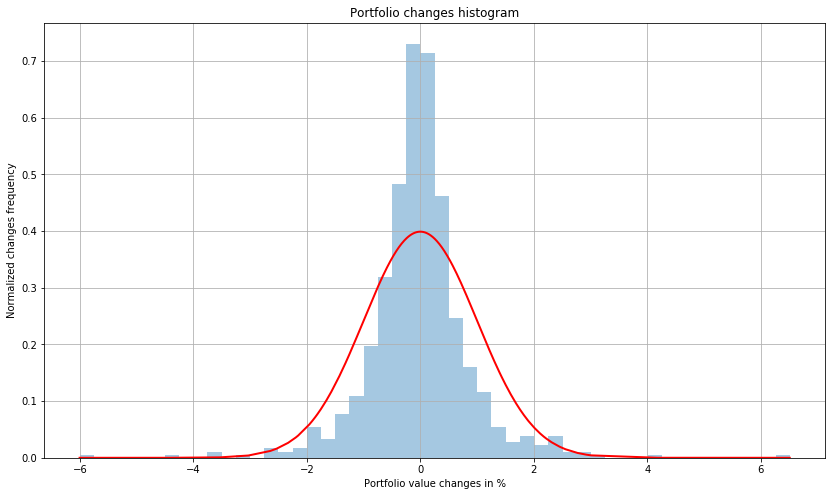

In [24]:
# plotting changes histogram and its normal distribution
norm_array = stats.norm.pdf(portfolio_changes) 
plt.figure(figsize=(14,8))
ax = sns.distplot(a=portfolio_changes, kde=False, norm_hist=True)
plt.grid()
plt.ylabel('Normalized changes frequency')
plt.xlabel('Portfolio value changes in %')
plt.title('Portfolio changes histogram')
ax.plot(portfolio_changes, norm_array, 'r', lw=2)
plt.show()

In [25]:
# standard deviation on exact data - portfolio value changes
std = np.std(portfolio_changes)

# variance-covariance VaR  with confident==99% - value of worst 1% portfolio value changes 
vc_var = np.round(- 2.33*std, 3)

# print results
print('Variance-covariance VaR for 1 day horizon and confidence interval equal to 99% is {} %'.format(vc_var))

Variance-covariance VaR for 1 day horizon and confidence interval equal to 99% is -2.101 %


### Answer

Variance-covariance VaR for 1 day horizon and confidence==99% is -2.101 %

# Question 4

## What would be historical simulation Value at Risk of the portfolio for 1 day horizon and confidence interval: 99%?


In [26]:
# first 5 portfolio values and value changes over time
values_and_changes.head()

,Value,Changes
2010-06-01,231831.778759,0.000000
2010-06-02,231217.779373,-0.265550
2010-06-03,231381.783040,0.070880
2010-06-04,232791.778967,0.605690
2010-06-07,233781.778742,0.423472


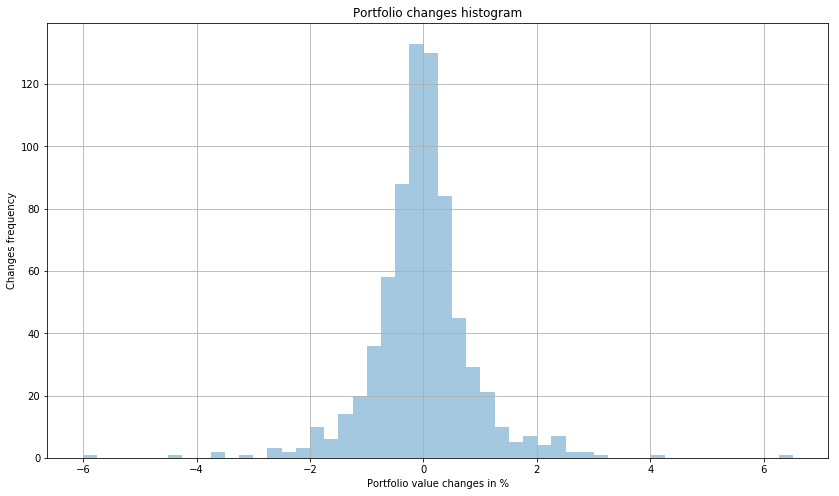

In [27]:
plt.figure(figsize=(14,8))
sns.distplot(a=portfolio_changes, kde=False, label='Actual portfolio value changes')
plt.grid()
plt.ylabel('Changes frequency')
plt.xlabel('Portfolio value changes in %')
plt.title('Portfolio changes histogram')
plt.show()

In [28]:
hist_var = np.round(var_historical(confident=99, df=portfolio_over_time),3)
print('Historical VaR for 1 day horizon and confidence interval equal to 99% is {} %'.format(hist_var))

Historical VaR for 1 day horizon and confidence interval equal to 99% is -2.531 %


### Answer

Historical VaR for 1 day horizon and confidence==99% is -2.531 %

# Question 5

## How would you test if variance-covaraince VaR is adequatelly measuring the risk? 

### Answer

I would compare variance-covariance VaR with historical VaR.

## Is the model performance acceptable?


Lets compare variance-covariance VaR with historical VaR which confident==99%.

In [29]:
print('Variance-covariance VaR with confident==99% is {}%'.format(vc_var))
print('Historical VaR with confident==99% is {}%'.format(hist_var))
print('Difference between these two VaR values is {}%'.format(np.round(np.abs(vc_var-hist_var), 3)))

Variance-covariance VaR with confident==99% is -2.101%
Historical VaR with confident==99% is -2.531%
Difference between these two VaR values is 0.43%


Lets compare variance-covariance VaR with historical VaR which confident==95%.

In [0]:
# variance-covariance VaR with confident 95%
vc_var_95= np.round(- 1.65*std, 3)

# historical VaR with confident 95%
hist_var_95 = np.round(var_historical(confident=95, df=portfolio_over_time),3)

In [31]:
print('Variance-covariance VaR with confident==95% is {}%'.format(vc_var_95))
print('Historical VaR with confident==95% is {}%'.format(hist_var_95))
print('Difference between these two VaR values is {}%'.format(np.round(np.abs(vc_var_95-hist_var_95), 3)))

Variance-covariance VaR with confident==95% is -1.488%
Historical VaR with confident==95% is -1.324%
Difference between these two VaR values is 0.164%


### Answer

Comparing variance-covariance VaR simulation and historical VaR simulation values with confident==99% difference is 0.43% what is around 16% and 20% of both VaR values and with confident==95% difference between these two VaR simulations is even smaller  - 0.164%, what is around 11% and 12% of both VaR values. Using both VaR simulations we took actual historical data so in both ways if we assuming that value should be distributed with normal distribution both variance-covariance and historical VaRs should be similar and we got that. Does the model perform is acceptable is hard to tell, it depends on the standarts company has.